# Dokumentacja wstępna 

## Filtr wykrywający krawędzie w wideo, w czasie rzeczywistym.

Funkcjonalność projektu:

- Poprawnie negocjuje parametry transmisji interfejsem HDMI.
- Odbiera strumień wideo z innego urządzenia.
- Wykonuje operacje wykrywania krawędzi w odebranym obrazie.
- Nanosi wykryte krawędzie na obraz wyjściowy.
- Nadaje strumień wideo na wyjście HDMI.

Projekt wykonywany na sprzęcie własnym. Na płytce [Nexys Video] z układem FPGA Xilinx Artix-7 XC7A200T-1SBG484C. Płytka jest wyposażona w potrzebne złącza wejście  HDMI i wyjście HDMI.

[Nexys Video]: https://reference.digilentinc.com/reference/programmable-logic/nexys-video/reference-manual?fbclid=IwAR33quUNPj1-sevbe4yfgbg7NtRSuu5IIi0UPC7HwtIQmubVyf3x_IuBAcM

## Analiza techniczna elementów systemu

### Interfejsy:

- wejście HDMI
- wyjście HDMI

W systemie HDMI dane pomiędzy odbiornikiem, a źródłem sygnału przesyłane są za pośrednictwem 4 kanałów TMDS. Trzy z nich wykorzystywane są do transmisji danych (audio, wideo, dane pomocnicze), jeden kanał służy do transmisji sygnałów zegarowych. W systemie wykorzystywana jest dodatkowo magistrala DDC (Display Data Channel), która służy do przesyłania danych dotyczących statusu i konfiguracji urządzeń nadawczych i odbiorczych. Można ją opcjonalnie wykorzystać do przesyłania danych protokołu CEC (Consumer Electronics Control). 
TDMS – transition minimized differential signalling, służy do przesyłania sygnału video, audio i danych pomocniczych. Podczas przesyłania danych video przesyła informację o kolorze kanałami RGB, a w przerwach między tymi wysyłkami przesyłane są pakiety audio.

### Algorytmy:

Algorytm do detekcji krawędzi dzieli się na pięć części.

- Konwersja na biało-czarne
- Redukcja szumu
- Obliczenie gradientu
- Dysktetyzacja

#### Konwersja na biało-czarne

Algorytm detekcji krawędzi działa na opbrazach biało-czarnych dlatego na początek wyznaczając średnią ze wszystkich kolorów zmieniamy obraz w białoczarny.

In [12]:
import numpy as np
import math
import cv2
import scipy.signal
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 5]

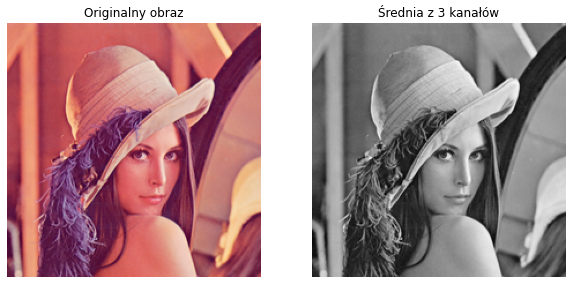

In [13]:
img = cv2.imread('lena.png',0)
color_img =  cv2.cvtColor(cv2.imread('lena.png'), cv2.COLOR_BGR2RGB)
img = color_img.mean(axis=2)
plt.subplot(121), plt.imshow(color_img), plt.axis('off'), plt.title('Originalny obraz')
plt.subplot(122), plt.imshow(img, cmap = 'gray'), plt.axis('off'), plt.title('Średnia z 3 kanałów'), plt.show();

#### Redukcja szumu

Jest to krok wstępny dla wielu metod wizji komputerowej. Polega na rozmyciu obrazu w celu zminimalizowania wpływu szumu na wynik działania algorytmu. Najczęściej stosuje się rozmycie gaussowskie. Polega ono na splocie obrazu z odpowiedzią filtru utworzoną na podstawie rozkładu normalnego.

In [14]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

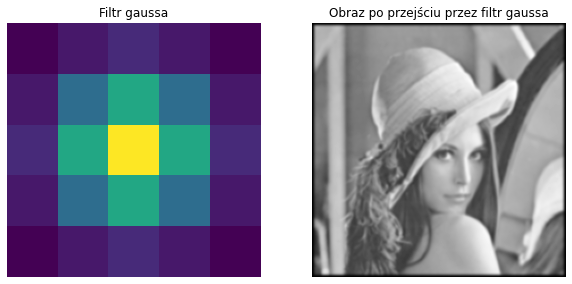

In [15]:
plt.subplot(121), plt.imshow(gaussian_kernel(5)), plt.axis('off')
plt.title('Filtr gaussa')
plt.subplot(122), plt.imshow(scipy.signal.convolve2d(img,gaussian_kernel(5)), cmap='gray')
plt.title('Obraz po przejściu przez filtr gaussa'), plt.axis('off'), plt.show();

#### Obliczanie gradientu

Do obliczenia przybliżenia gradientu korzystamy z operatora Sobela. Operator Sobela pozwala na wyznaczenie gradientu w danym kierunku. Na nasze potrzeby korzystamy z kierunku pionowego i poziomego.

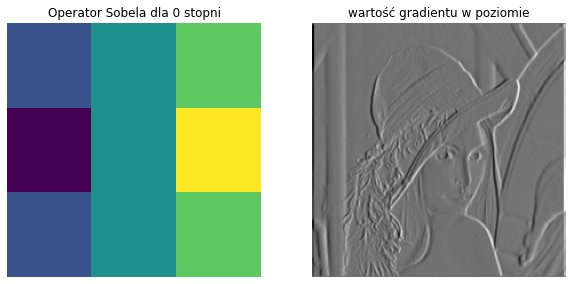

In [16]:
sobelKx = np.array([[-1,0,1],[-2,0,2], [-1,0,1]])
plt.subplot(121), plt.imshow(sobelKx), plt.axis('off'); plt.title('Operator Sobela dla 0 stopni')

Ix = scipy.signal.convolve2d(img,sobelKx)
plt.subplot(122), plt.imshow(Ix, cmap='gray'), plt.axis('off'), plt.title('wartość gradientu w poziomie')
plt.show();

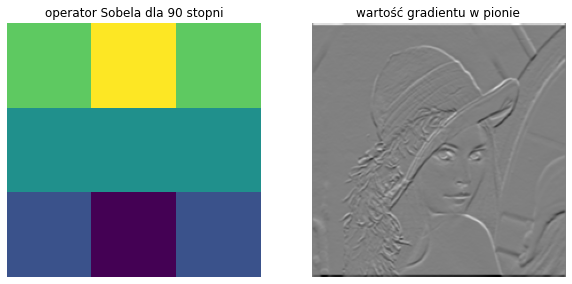

In [17]:
sobelKy = np.array([[1,2,1],[0,0,0], [-1,-2,-1]])
plt.subplot(121), plt.imshow(sobelKy), plt.axis('off'), plt.title("operator Sobela dla 90 stopni");
Iy = scipy.signal.convolve2d(img,sobelKy)
plt.subplot(122), plt.imshow(Iy, cmap='gray'), plt.axis('off'), plt.title('wartość gradientu w pionie'), plt.show();

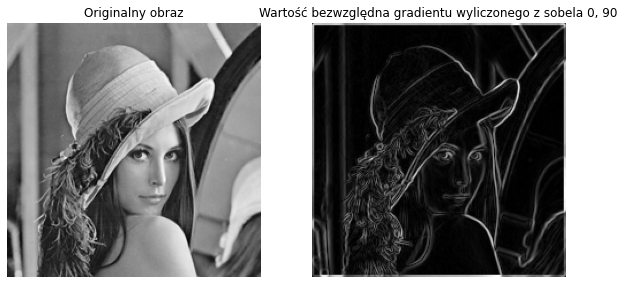

In [18]:
G = np.hypot(Ix, Iy)
G = G / G.max() * 255
G = G.astype('uint8')
plt.subplot(121), plt.imshow(img, cmap = 'gray'), plt.title('Originalny obraz'), plt.axis('off')
plt.subplot(122), plt.title('Wartość bezwzględna gradientu wyliczonego z sobela 0, 90'), plt.imshow(G, cmap='gray'), plt.axis('off'), plt.show();

In [19]:
theta = np.arctan2(Iy, Ix)

#### Dyskretyzacja

Aby krawędzie było lepiej widać zwiększamy ich wartość. Dyskretyzacja ma 2 poziomy aby nie utracić mniej ważnych krawędzi.

In [20]:
def double_treshold(img, treshold=(40,60)):
    temp = img.copy()
    with np.nditer(temp, op_flags=['readwrite']) as it:
        for i in it:
            if i < 40:
                i[...] = 0
            elif i < 60:
                i[...] = 125
            else:
                i[...] = 255
    return temp

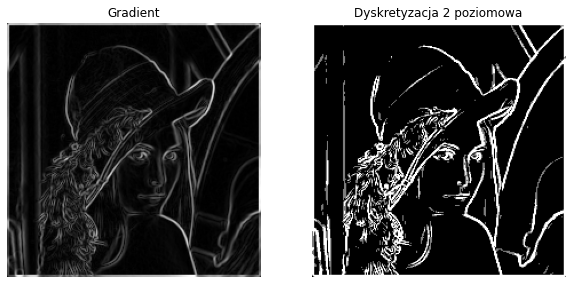

In [21]:
plt.subplot(122), plt.imshow( double_treshold(G), cmap='gray'), plt.axis('off'), plt.title('Dyskretyzacja 2 poziomowa')
plt.subplot(121), plt.imshow( G, cmap='gray'), plt.axis('off'), plt.title('Gradient'), plt.show();

#### Nałożenie wykrytych krawędzi na orginalny obraz

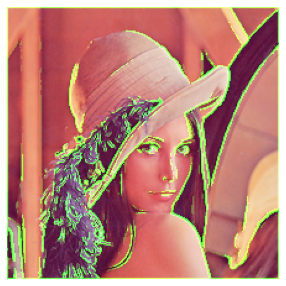

In [22]:
zero = np.zeros((220,220))
color_G = np.stack((zero, double_treshold(G)[1:221,1:221], zero), axis=2).astype('uint8')
plt.imshow(np.maximum(color_G,color_img)), plt.axis("off"), plt.show();

## Status prac

### Obecnie.
* Zastąpienie funkcji exp() LUTem w odpowiendnim zakresie (realizacja stałoprzecinkowa).
* Zastąpienie funkcji odpowiadającą za splot dwuwymiarowy (potrzebny przy realizacji filtru sobelowskiego) inną implementacją, zgodną z możliwościami generowania kodu zgodnego z HDL.

### Przyszłe kroki.
* Implementacja i weryfikacja układu na płytce Nexys Video.
* Uzyskanie licencji na IP Core odpowiadający za transmisję HDMI (niestety, IP Core jest płatny i można pozwolić sobie jedynie na ewaluację ograniczoną czasowo).
* Zrealizowania zaznaczania krawędzi (jak widoczne na ostatnim obrazku).

## Uwagi.

W dokumentacji wstępnej użyte zostały biblioteki języka Python, jednak ze względu na możliwość generacji kodu w HDL oraz ogólnie symulowania i debugowania kodu, używany jest też program Matlab/Simulink z odpowiednimi Toolboxami (przetwarzanie obrazów, HDL Coder,...).

<p align="right"><br><b>Wykonawcy</b> Wiktor Szczerek <br> Filip Kulik <br> Jacek Dobrowolski </p>